# '코로나19' 키워드 네이버 기사 토픽 모델링

## 네이버 기사 Summary 크롤링

In [1]:
# -*- coding: utf-8 -*-

from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
from konlpy.tag import Komoran
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from pyclustering.cluster import kmedoids
import numpy as np
import re
import requests
from gensim import corpora, models
import gensim


In [45]:
title_text=[]
link_text=[]
source_text=[]
contents_text=[]
result={}

In [32]:
RESULT_PATH ='./'

In [33]:
def contents_cleansing(contents):
    first_cleansing_contents = re.sub('<dl>.*?</a> </div> </dd> <dd>', '', 
                                      str(contents)).strip()  #앞에 필요없는 부분 제거
    second_cleansing_contents = re.sub('<ul class="relation_lst">.*?</dd>', '', 
                                       first_cleansing_contents).strip()#뒤에 필요없는 부분 제거 (새끼 기사)
    third_cleansing_contents = re.sub('<.+?>', '', second_cleansing_contents).strip()
    contents_text.append(third_cleansing_contents)
    #print(contents_text)

In [34]:
def crawler(maxpage,query,sort,s_date,e_date):

    s_from = s_date.replace(".","")
    e_to = e_date.replace(".","")
    page = 1  
    maxpage_t =(int(maxpage)-1)*10+1   # 11= 2페이지 21=3페이지 31=4페이지  ...81=9페이지 , 91=10페이지, 101=11페이지
    
    while page <= maxpage_t:
        url = "https://search.naver.com/search.naver?where=news&query=" + query + "&sort="+sort+"&ds=" + s_date + "&de=" + e_date + "&nso=so%3Ar%2Cp%3Afrom" + s_from + "to" + e_to + "%2Ca%3A&start=" + str(page)
        
        response = requests.get(url)
        html = response.text
 
        soup = BeautifulSoup(html, 'html.parser')
 
        atags = soup.select('._sp_each_title')
        for atag in atags:
            title_text.append(atag.text)     
            link_text.append(atag['href'])   
            
        source_lists = soup.select('._sp_each_source')
        for source_list in source_lists:
            source_text.append(source_list.text)
               
        contents_lists = soup.select('ul.type01 dl')
        for contents_list in contents_lists:
            #print('==='*40)
            #print(contents_list)
            contents_cleansing(contents_list) 
        
        result= {"title":title_text ,  "source" : source_text ,"contents": contents_text ,"link":link_text }  
        print(page)
        
        df = pd.DataFrame(result)  
        page += 10
             
    outputFileName = '1번.xlsx'
    df.to_excel(RESULT_PATH+outputFileName, sheet_name='sheet1')

In [35]:
def main():
    info_main = input("="*50+"\n"+"입력 형식에 맞게 입력해주세요."+"\n"+" 시작하시려면 Enter를 눌러주세요."+"\n"+"="*50)
    
    maxpage = input("최대 크롤링할 페이지 수 입력하시오: ")  
    query = input("검색어 입력: ")  
    sort = input("뉴스 검색 방식 입력(관련도순=0  최신순=1  오래된순=2): ")    
    s_date = input("시작날짜 입력(2019.01.04):") 
    e_date = input("끝날짜 입력(2019.01.05):")   
    
    crawler(maxpage,query,sort,s_date,e_date) 
    
main()

입력 형식에 맞게 입력해주세요.
 시작하시려면 Enter를 눌러주세요.
최대 크롤링할 페이지 수 입력하시오: 101
검색어 입력: 코로나19
뉴스 검색 방식 입력(관련도순=0  최신순=1  오래된순=2): 1
시작날짜 입력(2019.01.04):2020.02.01
끝날짜 입력(2019.01.05):2020.05.15
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391
401
411
421
431
441
451
461
471
481
491
501
511
521
531
541
551
561
571
581
591
601
611
621
631
641
651
661
671
681
691
701
711
721
731
741
751
761
771
781
791
801
811
821
831
841
851
861
871
881
891
901
911
921
931
941
951
961
971
981
991
1001


## 전처리

In [2]:
komo = Komoran()
Data = pd.read_excel('1번.xlsx')

Data.tail()

,Unnamed: 0,title,source,contents,link
1005,1005,"[이슈]전국한우협회 한우 플랫폼 사업 본격화, HMR 출시 '신호탄' 下",농수축산신문,특히 코로나19 영향으로 오프라인 매출이 감소하고 고객 맞춤형 포장단위와 새벽배송 ...,http://www.aflnews.co.kr/news/articleView.html...
1006,1006,"금산인삼, 코로나19 대응 효능연구 나선다",농수축산신문,금산군이 금산인삼의 코로나19 감염억제 효능에 대한 연구를 추진한다. 금산국제인삼약...,http://www.aflnews.co.kr/news/articleView.html...
1007,1007,인천서 세 번째 3차 감염…자가격리 어긴 60대 고발,MBN언론사 선정,클럽에 갔다 코로나19가 확진된 학원강사의 3차 감염자가 또 나왔습니다. 클럽에 다...,http://www.mbn.co.kr/pages/news/newsView.php?n...
1008,1008,경쟁력있는 창업아이템은 왜? 소비트랜드 잘 맞아,머니S,코로나19로 새로운 외식문화가 형성되면서 오랜기간 검증받은 아이템은 이시기에도 튼튼...,http://moneys.mt.co.kr/news/mwView.php?no=2020...
1009,1009,"이재명, 임진각 ‘드라이브스루 장터’ 개장",헤럴드경제,"‘마켓경기’ 온라인 쇼핑몰도 항시 열려 있습니다. 품질 좋은 경기도산 농특산물, 계...",http://news.heraldcorp.com/view.php?ud=2020051...


In [3]:
contents = []
for i in Data['contents']:
    contents.append(i)
contents

['계룡시 관계자는 "코로나19로 달라진 일상생활과 지역경제 활성화를 위한 시민들의 참신한 아이디어와 사업이 예산에 반영돼 더 나은 계룡의 발전을 기대한다"면서 "주민이 진정으로 원하는 곳에 원하는 예산이 쓰여질...',
 '【 STD 】 코로나19로 인해 5·18민주화운동 40주년 기념 공연은 이렇게 관객 없이 진행됐습니다. 서울시는 5·18민주화운동 40주년을 맞아 처음으로 광주시와 함께 오월평화페스티벌을 마련했습니다. 【 INT 】이동연...',
 '장운합기자=익산시 기독교연합회는 15일, 코로나19로 어려움을 겪고 있는 어르신들을 위해 백미50포(20kg)와 라면50박스를 익산시노인종합복지관에 전달했다. 사진출처=익산시청 제공[사진-정헌율 시장과 기독교연합회...',
 '신종 코로나바이러스 감염증(코로나19) 여파로 미국의 4월 소매판매가 역사상 최대 폭락치를 기록했다. CNN등 외신에 따르면 미 상무부는 15일(현지 시간) 미국의 4월 소매판매가 16.4% 하락했다고 발표했다. 통계를...',
 '사진-주민자치협의회 정기정 위원장 정 위원장 가족은 14일, 익산시를 방문해 지난 5월 초 지급받은 익산시 재난기본소득 60만원과 정부 긴급재난지원금 100만원 등 총 160만원을 코로나19로 생계에 곤란을 겪고 있는 가정을...',
 '이우문 율곡동장은 "코로나19로 인한 방역활동, 분무기 소독약 배부, 마스크 배부, 국회의원 선거, 경상북도 재난 긴급생활비 지원 홍보 등 적극적인 협조를 해 주신 통장님들께 감사를 전한다."고 하면서 이번 정부...',
 '미중 코로나19 무역전쟁 전운 고조 속 中 겨냥 "대만과의 관계 강화" 송수경 특파원 = 미국은 15일(현지시간) 세계 최대 반도체 위탁생산 업체인 대만의 TSMC가 미국 애리조나에 첨단 반도체 공장을 설립하기로 한 데 대해...',
 '청주시는 코로나19로 일시 중단한\xa0무료법률상담 서비스를 다음달까지\xa0전화 상담으로 변경해 운영하기로 했습니다. 상담 신청은 매월 1일 선착순 12명까지\xa0시

In [4]:
def cleansing(text):
    pattern = '([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)' 
    text = re.sub(pattern=pattern, repl='', string=text)
   # pattern = '(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+' 
   # text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '([ㄱ-ㅎㅏ-ㅣ]+)' 
    text = re.sub(pattern=pattern, repl='', string=text)
   # pattern = '<[^>]*>'     
   # text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '[^\w\s]'
    text = re.sub(pattern=pattern, repl='', string=text)
    return text 

In [5]:
clean_contents = []
for text in contents:
    a = cleansing(str(text))
    clean_contents.append(a)
clean_contents

['계룡시 관계자는 코로나19로 달라진 일상생활과 지역경제 활성화를 위한 시민들의 참신한 아이디어와 사업이 예산에 반영돼 더 나은 계룡의 발전을 기대한다면서 주민이 진정으로 원하는 곳에 원하는 예산이 쓰여질',
 ' STD  코로나19로 인해 518민주화운동 40주년 기념 공연은 이렇게 관객 없이 진행됐습니다 서울시는 518민주화운동 40주년을 맞아 처음으로 광주시와 함께 오월평화페스티벌을 마련했습니다  INT 이동연',
 '장운합기자익산시 기독교연합회는 15일 코로나19로 어려움을 겪고 있는 어르신들을 위해 백미50포20kg와 라면50박스를 익산시노인종합복지관에 전달했다 사진출처익산시청 제공사진정헌율 시장과 기독교연합회',
 '신종 코로나바이러스 감염증코로나19 여파로 미국의 4월 소매판매가 역사상 최대 폭락치를 기록했다 CNN등 외신에 따르면 미 상무부는 15일현지 시간 미국의 4월 소매판매가 164 하락했다고 발표했다 통계를',
 '사진주민자치협의회 정기정 위원장 정 위원장 가족은 14일 익산시를 방문해 지난 5월 초 지급받은 익산시 재난기본소득 60만원과 정부 긴급재난지원금 100만원 등 총 160만원을 코로나19로 생계에 곤란을 겪고 있는 가정을',
 '이우문 율곡동장은 코로나19로 인한 방역활동 분무기 소독약 배부 마스크 배부 국회의원 선거 경상북도 재난 긴급생활비 지원 홍보 등 적극적인 협조를 해 주신 통장님들께 감사를 전한다고 하면서 이번 정부',
 '미중 코로나19 무역전쟁 전운 고조 속 中 겨냥 대만과의 관계 강화 송수경 특파원  미국은 15일현지시간 세계 최대 반도체 위탁생산 업체인 대만의 TSMC가 미국 애리조나에 첨단 반도체 공장을 설립하기로 한 데 대해',
 '청주시는 코로나19로 일시 중단한\xa0무료법률상담 서비스를 다음달까지\xa0전화 상담으로 변경해 운영하기로 했습니다 상담 신청은 매월 1일 선착순 12명까지\xa0시 민원과로 할 수 있고\xa0상담은 매월 둘째 주에',
 '어려울 부탁을 드리면 은 기간이지만 고용을 해준다며 아

In [6]:
nouns = []
for text in clean_contents:
    nouns.append(komo.nouns(text))
nouns

[['계룡시',
  '관계자',
  '코로나',
  '19',
  '일상생활',
  '지역',
  '경제',
  '활성',
  '시민',
  '아이디어',
  '사업',
  '예산',
  '반영',
  '발전',
  '기대',
  '주민',
  '진정',
  '곳',
  '예산'],
 ['코로나',
  '19',
  '인해',
  '민주화',
  '운동',
  '주년',
  '기념',
  '공연',
  '관객',
  '진행',
  '서울시',
  '민주화',
  '운동',
  '주년',
  '처음',
  '광주시',
  '오월',
  '평화',
  '페스티벌',
  '마련',
  '이동',
  '연'],
 ['장',
  '운',
  '합',
  '기자',
  '익산시',
  '기독교',
  '연합회',
  '일',
  '코로나',
  '19',
  '어려움',
  '어르신',
  '백미',
  '50',
  '포',
  '라면',
  '50',
  '박스',
  '익산시',
  '노인',
  '종합',
  '복지관',
  '전달',
  '사진',
  '출처',
  '익산시',
  '청',
  '제공',
  '사진',
  '정헌',
  '시장',
  '기독교',
  '연합회'],
 ['신종',
  '코로나바이러스',
  '감염증',
  '코로나',
  '19',
  '여파',
  '미국',
  '4월',
  '소매',
  '판매',
  '역사',
  '최대',
  '폭락',
  '기록',
  '등',
  '외신',
  '미',
  '상무부',
  '일',
  '현지',
  '시간',
  '미국',
  '4월',
  '소매',
  '판매',
  '하락',
  '발표',
  '통계'],
 ['사진',
  '주민',
  '자치',
  '협의회',
  '정기',
  '정',
  '위원장',
  '정',
  '위원장',
  '가족',
  '일',
  '익산시',
  '방문',
  '5월',
  '초',
  '지급',
  '익산시',
  '재난',
  '기본소득',
  '

In [7]:
stopwords = ['것', '코로나', '19', '일', '명', '자', '수', '곳', '등', '원', '씨', '중', '날', '주', '코로나바이러스', '이번'] ## 검색어도 빼주었다.

Nouns = []
for sentence in nouns:
    filtered_words=[]
    for word in sentence:
        if word not in stopwords:
            filtered_words.append(word)
    Nouns.append(filtered_words)
Nouns

[['계룡시',
  '관계자',
  '일상생활',
  '지역',
  '경제',
  '활성',
  '시민',
  '아이디어',
  '사업',
  '예산',
  '반영',
  '발전',
  '기대',
  '주민',
  '진정',
  '예산'],
 ['인해',
  '민주화',
  '운동',
  '주년',
  '기념',
  '공연',
  '관객',
  '진행',
  '서울시',
  '민주화',
  '운동',
  '주년',
  '처음',
  '광주시',
  '오월',
  '평화',
  '페스티벌',
  '마련',
  '이동',
  '연'],
 ['장',
  '운',
  '합',
  '기자',
  '익산시',
  '기독교',
  '연합회',
  '어려움',
  '어르신',
  '백미',
  '50',
  '포',
  '라면',
  '50',
  '박스',
  '익산시',
  '노인',
  '종합',
  '복지관',
  '전달',
  '사진',
  '출처',
  '익산시',
  '청',
  '제공',
  '사진',
  '정헌',
  '시장',
  '기독교',
  '연합회'],
 ['신종',
  '감염증',
  '여파',
  '미국',
  '4월',
  '소매',
  '판매',
  '역사',
  '최대',
  '폭락',
  '기록',
  '외신',
  '미',
  '상무부',
  '현지',
  '시간',
  '미국',
  '4월',
  '소매',
  '판매',
  '하락',
  '발표',
  '통계'],
 ['사진',
  '주민',
  '자치',
  '협의회',
  '정기',
  '정',
  '위원장',
  '정',
  '위원장',
  '가족',
  '익산시',
  '방문',
  '5월',
  '초',
  '지급',
  '익산시',
  '재난',
  '기본소득',
  '만원',
  '정부',
  '긴급',
  '재난',
  '지원금',
  '만원',
  '만원',
  '생계',
  '곤란',
  '가정'],
 ['우문',
  '율곡동',
  '장',
  '방역',
  '활동

In [8]:
dictionary = corpora.Dictionary(Nouns)

print(dictionary)

Dictionary(4326 unique tokens: ['경제', '계룡시', '관계자', '기대', '반영']...)


In [9]:
corpus = [dictionary.doc2bow(text) for text in Nouns]

print(corpus)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)], [(15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1)], [(32, 2), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 3), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1)], [(56, 2), (57, 1), (58, 1), (59, 1), (60, 2), (61, 1), (62, 1), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 2), (72, 1), (73, 1), (74, 1)], [(11, 1), (40, 1), (46, 2), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 3), (82, 1), (83, 1), (84, 2), (85, 1), (86, 2), (87, 2), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1)], [(47, 1), (80, 1), (86, 1), (89, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 2), (101, 1), (102, 1), (103,

## 최적의 토픽 개수를 선정 -> 토픽 모델링 실시

In [10]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word = dictionary)

ldamodel.print_topics(num_words=10)

[(0,
  '0.011*"신종" + 0.010*"감염증" + 0.009*"확진" + 0.008*"확산" + 0.006*"분기" + 0.006*"사태" + 0.005*"여파" + 0.005*"경기" + 0.004*"올해" + 0.004*"중국"'),
 (1,
  '0.010*"확진" + 0.007*"기자" + 0.006*"감염" + 0.005*"지역" + 0.005*"확산" + 0.005*"판정" + 0.005*"사태" + 0.004*"감염증" + 0.004*"신종" + 0.004*"이태원"'),
 (2,
  '0.010*"감염증" + 0.010*"신종" + 0.009*"확진" + 0.007*"이태원" + 0.006*"중국" + 0.006*"클럽" + 0.005*"미국" + 0.005*"차" + 0.005*"경제" + 0.005*"사태"')]

In [11]:
NUM_TOPICS = 3
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.010*"감염증" + 0.009*"신종" + 0.009*"분기" + 0.007*"중국" + 0.007*"미국"')
(1, '0.008*"확진" + 0.008*"신종" + 0.008*"감염증" + 0.007*"감염" + 0.007*"이태원"')
(2, '0.015*"확진" + 0.008*"확산" + 0.007*"신종" + 0.007*"판정" + 0.007*"감염증"')


In [12]:
for idx, topic in ldamodel.show_topics(formatted=False, num_words= 10):
    print('Topic: {} \nWords: {}'.format(idx, [w[0] for w in topic]))

Topic: 0 
Words: ['감염증', '신종', '분기', '중국', '미국', '확산', '대통령', '세계', '영업', '사태']
Topic: 1 
Words: ['확진', '신종', '감염증', '감염', '이태원', '경제', '클럽', '정부', '사태', '서울']
Topic: 2 
Words: ['확진', '확산', '신종', '판정', '감염증', '일본', '사태', '지역', '감염', '김']


In [13]:
ldamodel.get_document_topics(corpus)[5]

[(0, 0.014536457), (1, 0.9694752), (2, 0.015988339)]

In [14]:
from gensim.models import CoherenceModel

print('\nPerplexity: ', ldamodel.log_perplexity(corpus))
coherence_model_lda = CoherenceModel(model=ldamodel, texts=nouns, dictionary=dictionary,topn=10)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.7964300360275605

Coherence Score:  0.2638515571378479


In [15]:
import matplotlib.pyplot as plt

perplexity_values = []
for i in range(2,10):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word = dictionary)
    perplexity_values.append(ldamodel.log_perplexity(corpus))

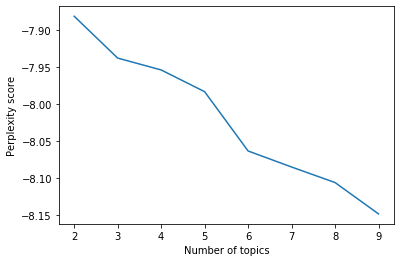

In [18]:
x = range(2,10)
plt.plot(x, perplexity_values)
plt.xlabel("Number of topics")
plt.ylabel("Perplexity score")
plt.show()

In [ ]:
coherence_values = []
for i in range(2,10):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word = dictionary)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=nouns, dictionary=dictionary,topn=10)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

Exception ignored in: <function _ConnectionBase.__del__ at 0x1188ea5f0>
Traceback (most recent call last):
  File "/Users/kim_yoonhye/.pyenv/versions/anaconda3-2019.10/lib/python3.7/multiprocessing/connection.py", line 130, in __del__
    def __del__(self):
KeyboardInterrupt


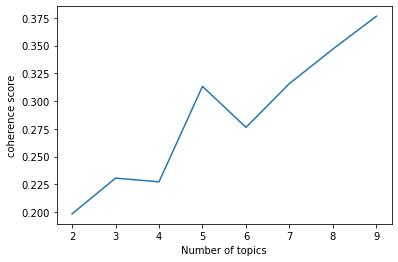

In [17]:
x = range(2,10)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.show()

## 시각화

In [19]:
import pyLDAvis.gensim as gensimvis

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=8, id2word = dictionary)
prepared_data = gensimvis.prepare(ldamodel, corpus, dictionary)

In [20]:
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

pyLDAvis.display(prepared_data)

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="/System/Library/Fonts/AppleSDGothicNeo.ttc").get_name()
rc('font', family=font_name)

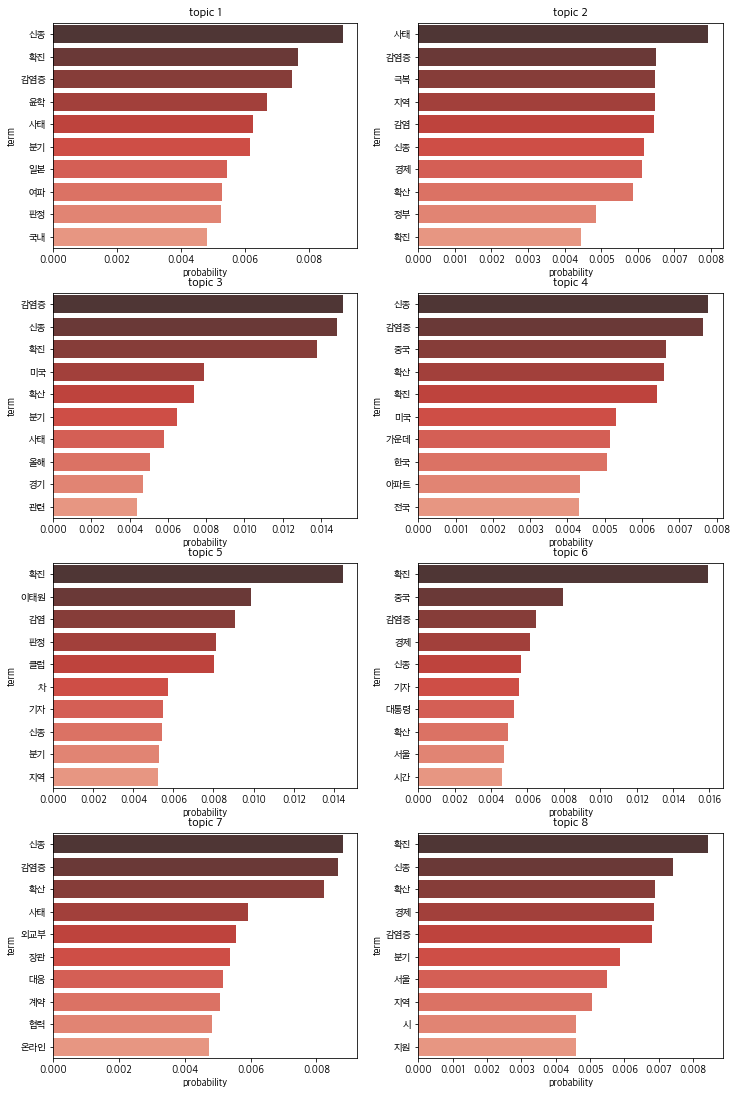

In [24]:
fiz=plt.figure(figsize=(12,24))
for i in range(8):
    df=pd.DataFrame(ldamodel.show_topic(i), columns=['term','prob']).set_index('term')
#     df=df.sort_values('prob')
    
    plt.subplot(5,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df, label='Cities', palette='Reds_d')
    plt.xlabel('probability')
    
plt.show()